# **Avant de modifier ce notebook, bien penser a faire une copie dans son drive via fichier --> enregistrer une copie dans drive**

# Telechargement et visualisation des données 

Dans ce notebook nous allons prendre un dataset contenant des valeurs météorologiques en focntion du temps et essayer avec un reseaux de neuronnes recurent de prédire la temperature future 

On importe les bibliotheques necessaires 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Il faut telecharger les fichier sur le lien [kaggle](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data) 

Avec la fonction `read_csv`, on lit les fichiers et on les stocke dans un DataFrame df

On indique `index_col='date'` car on veut que la colonne des dates du dataset soit l'index du dataframe, de plus on indique p`arse_dates = True` pour que pandas considere ca comme une serie temporelle

In [ ]:
df = pd.read_csv('DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)


`head()` nous permet de voir les premieres lignes de notre dataset

In [ ]:
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


Nous allons travailler que sur une seule mesure, qui sera celle de la temperature, nous allons donc supprimer toutes les autres colonnes du tableau 

In [ ]:
df = df.drop('humidity', axis=1)
df = df.drop('wind_speed', axis=1)
df = df.drop('meanpressure', axis=1)


On peut afficher la courbe des temperature en fonction du temps 

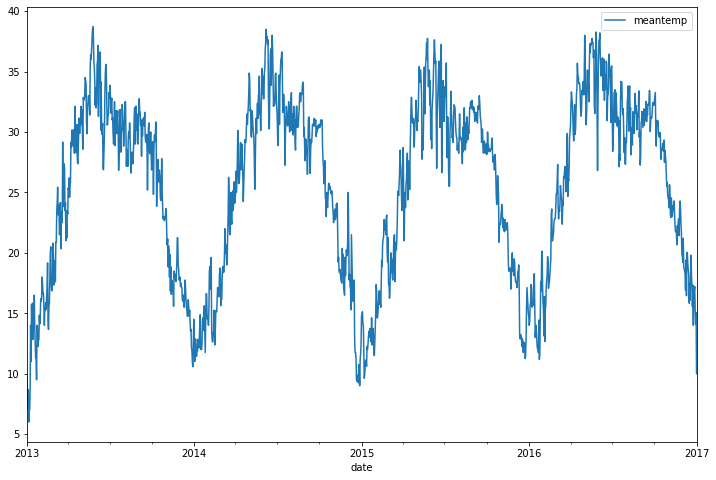

In [ ]:
df.plot(figsize=(12,8))

# Separation en données de test et données d'entrainement

In [ ]:
len(df)

1462

On va prendre les 100 dernieres valeurs pour notre jeu de test, et donc les 1362 premieres pour notre jeu d'entrainement, on affiche les valeurs de test et train pour etre sur

In [ ]:
train = df.iloc[:1362]
test = df.iloc[-100:]

print(len(train))
print(len(test))

1362
100


# Normalisation des données 

on importe la bibliotheque nous permettant de faire de la mise a l'echelle 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

On crée une instance de `MinMaxscaler`, et on lui donne train comme modele pour s'entrainer a normaliser 

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

`scaler.transform()` met a l'echelle le dataframe 

In [ ]:
scaled_train = scaler.transform(train)


In [ ]:
scaled_test = scaler.transform(test)

# Creation d'un générator 

On importe les bibliotheques necessaires a la création d'un générator

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

`TmeseriesGenerator` prend en argument les data, les target, puis `lenght`, le nombre de data que l'on veut prendre en compte, et `batch_size`, le nombre de target que l'on veut

In [ ]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=12, batch_size=1)

On voit que notre générator prend les 12 premieres valeurs de scaled_train, ainsi que la 13 eme valeur qui sera la target

In [ ]:
generator[0]

(array([[[0.12227074],
         [0.04279476],
         [0.0356623 ],
         [0.08151383],
         [0.        ],
         [0.03056769],
         [0.03056769],
         [0.08733624],
         [0.24454148],
         [0.15283843],
         [0.29694323],
         [0.24454148]]]), array([[0.30058224]]))

# Creation d'un modele

On importe les bibliotheques, nous allons utiliser deux couches, Dense et LSTM 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

**Nous créons un modele de type séquentiel**

nous ajoutons une couche LSTM avec `model.add()`, cette couche prend en argument le nombre de neuronnes ici 100, la fonction d'activation, dans notre cas relu, mais cela depend de l'application que l'on fait avec le RNN, la shape d'entrée elle va etre celle dugénérator, 12 valeurs pour une sortie 

il faut toujours ajouter une couche dense pour les sorties des modeles, la derniere couche dense prend en parametre le nombre de features, c est a dire le nombre de sortie que l'on veut predire, dans notre ca nous voulons prendire qu'une seule valeur en se basant sur les 12 precedente 

`model.compile` prend en parametre un optimizer, dans notre cas adam, mais comme la fonction d'activation cela peut changer en fonction de l'application.

loss représente l'erreur entre la prediction et le resultat reel, c'est cette valeur qui va etre améliorée par le modele, dans notre cas nous avons choisi mse, mean squared error

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu',return_sequences=False, input_shape=(12,1)))
#model.add(LSTM(100, activation='relu',return_sequences=True, input_shape=(12,1)))

model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

`Model.summary()` permet d'avoir un récapitulatif de notre modele

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# Entainement du modele 

`model.fi`t permet d'entrainer le modele, il prend en parametre les données d'entrainement, ici notre generator, et le nombre d'epochs, ce qui correspond au nombre de passage sur l'intégralité de nos données. 

Le nombre d'epochs est un parametre sur lequel on peut jouer pour ameliorer la precision du modele, si il y a trop d'epochs, un phenome d'overfitting peut arriver, et pas assez d'epochs le modele ne sera pas assez entrainé

In [ ]:
model.fit(generator, epochs=20)

Epoch 1/20
1350/1350 [==============================] - 9s 6ms/step - loss: 0.0276
Epoch 2/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0045
Epoch 3/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0038
Epoch 4/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0033
Epoch 5/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0030
Epoch 6/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0031
Epoch 7/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0028
Epoch 8/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0030
Epoch 9/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0028
Epoch 10/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0029
Epoch 11/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0027
Epoch 12/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0026
E

on peut visualiser nos pertes "loss", on voit bien que plus notre modele s'entraine moins il y a d'erreurs

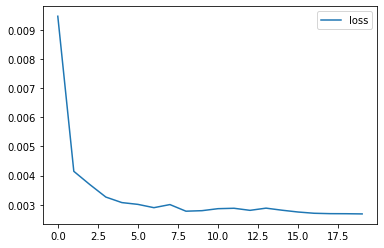

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

# Verification de nos resultats 

On crée un boucle for qui va dans un premier temps predire une valeur en utilisant les 12 dernieres valeurs de train, puis on va stocker cette valeur dans un tableau de prediction, et de nouveau predire une valeur en utilisant la derniere valeur predite 

On va ensuite comparer ces valeurs avec les valeurs de test

In [ ]:
prediction = []
curr_batch=scaled_train[-12:]
curr_batch = curr_batch.reshape(1,12,1)
for i in range( len(test)):
  curr_pred = model.predict(curr_batch)[0]
  prediction.append(curr_pred)
  curr_batch = np.append(curr_batch[:,1:,:], [[curr_pred]], axis=1)

Nos prediction etaient normalisée, il faut donc les re transformer

In [ ]:
true_pred = scaler.inverse_transform(prediction)

on ajoute notre colonne `true_pred` a notre dataframe de test, nous allons pouvoir comparer nos resultats

In [ ]:
test['prediction'] = true_pred

On voit que les valeurs predites sont proches des valeurs reeles, il est possible d'ameliorer la precision du modele en jouant sur le nombre d'epochs, ou sur les couches de notre modele 

In [ ]:
test

In [ ]:
test.plot()